# Dask-GeoPandas Sorted

In [1]:
import time
from datetime import datetime
from pathlib import Path

import geopandas
import dask_geopandas

import dask.dataframe as dd
from distributed import LocalCluster, Client

In [2]:
# set up data paths
base_path = Path().cwd().parent.parent
data_dir = base_path.joinpath('data')

In [3]:
# create local dask cluster
cluster = LocalCluster(#silence_logs=logging.ERROR,
                       dashboard_address=':8790',
                       n_workers=1,
                       threads_per_worker=4,
                       memory_limit='8 GB')
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8790/status,
Dashboard: http://127.0.0.1:8790/status,Workers: 1
Total threads: 4,Total memory: 7.45 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42035,Workers: 1
Dashboard: http://127.0.0.1:8790/status,Total threads: 4
Started: Just now,Total memory: 7.45 GiB
Comm: tcp://192.168.0.118:41947,Total threads: 4
Dashboard: http://192.168.0.118:37381/status,Memory: 7.45 GiB
Nanny: tcp://127.0.0.1:41177,


In [4]:
# load spatially sorted us data
spatial_sort_path = data_dir.joinpath('us_cont_spatiallysorted_geopandas_100.parquet')
df = dask_geopandas.read_parquet(spatial_sort_path)
df

,latitude,longitude,geometry
npartitions=100,,,
25629,float64,float64,geometry
108754622,...,...,...
...,...,...,...
963106280,...,...,...
1073720176,...,...,...


In [5]:
df.head(2)

,latitude,longitude,geometry
hilbert_distance,,,
25629,24.447,-124.443,POINT (-124.44300 24.44700)
99850,24.704,-124.532,POINT (-124.53200 24.70400)


In [6]:
len_df = len(df)
len_df

113944489

<AxesSubplot:>

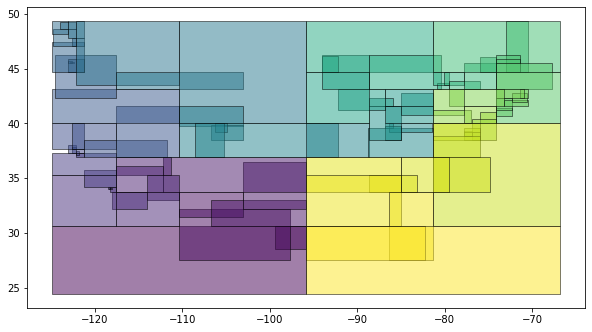

In [7]:
df.spatial_partitions.plot(cmap="viridis", alpha=0.5, edgecolor="k", figsize=(10, 6))

## Joining with a geopandas.GeoDataFrame


In [8]:
# load various size subsets of the zip code data as geopandas.GeoDataFrames
zips_1 = geopandas.read_parquet(data_dir.joinpath('zip_codes', 'zips_1.parquet')).loc[:, ['geometry']]
zips_10 = geopandas.read_parquet(data_dir.joinpath('zip_codes', 'zips_10.parquet')).loc[:, ['geometry']]
zips_100 = geopandas.read_parquet(data_dir.joinpath('zip_codes', 'zips_100.parquet')).loc[:, ['geometry']]
zips_1000 = geopandas.read_parquet(data_dir.joinpath('zip_codes', 'zips_1000.parquet')).loc[:, ['geometry']]
zips_10000 = geopandas.read_parquet(data_dir.joinpath('zip_codes', 'zips_10000.parquet')).loc[:, ['geometry']]

In [9]:
zips_1b = dask_geopandas.from_geopandas(zips_1, npartitions=1)
zips_10b = dask_geopandas.from_geopandas(zips_10, npartitions=1)
zips_100b = dask_geopandas.from_geopandas(zips_100, npartitions=1)
zips_1000b = dask_geopandas.from_geopandas(zips_1000, npartitions=1)
zips_10000b = dask_geopandas.from_geopandas(zips_10000, npartitions=1)

In [10]:
zips_1b.spatial_partitions = geopandas.GeoSeries([zips_1b.envelope.unary_union.compute()], crs=df.crs)
zips_10b.spatial_partitions = geopandas.GeoSeries([zips_10b.envelope.unary_union.compute()], crs=df.crs)
zips_100b.spatial_partitions = geopandas.GeoSeries([zips_100b.envelope.unary_union.compute()], crs=df.crs)
zips_1000b.spatial_partitions = geopandas.GeoSeries([zips_1000b.envelope.unary_union.compute()], crs=df.crs)
zips_10000b.spatial_partitions = geopandas.GeoSeries([zips_10000b.envelope.unary_union.compute()], crs=df.crs)

In [11]:
%%time
total_points = len_df
num_partitions = df.npartitions
num_polygons = []
time_sec = []
num_result_points = []
num_result_partitions = []
num_points = len_df

t00 = time.time()
for zip_gdf in [zips_1b, zips_10b, zips_100b, zips_1000b, zips_10000b]:
    num_polygons.append(len(zip_gdf))
    t0 = time.time()
    
    rdf = dask_geopandas.sjoin(df, zip_gdf, how='inner', op="within")
    # calculate lenght as cheap operation to avoid computing the full resulting frame into memory
    len_result = len(rdf)
    
    time_sec.append(time.time() - t0)
    num_result_points.append(len_result)
    num_result_partitions.append(rdf.npartitions)
    print(f'num_polygons[-1]: {num_polygons[-1]}, time_sec[-1]: {time_sec[-1]:.0f} s')

/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, glob, local_ns)


num_polygons[-1]: 1, time_sec[-1]: 3 s


/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, glob, local_ns)


num_polygons[-1]: 10, time_sec[-1]: 34 s


/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, glob, local_ns)


num_polygons[-1]: 100, time_sec[-1]: 110 s


/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, glob, local_ns)


num_polygons[-1]: 1000, time_sec[-1]: 149 s


/home/joris/miniconda3/envs/geo/lib/python3.9/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code, glob, local_ns)


num_polygons[-1]: 10000, time_sec[-1]: 187 s
CPU times: user 40.4 s, sys: 3.04 s, total: 43.4 s
Wall time: 8min 6s


In [12]:
# save summary info to file
results_df = pd.DataFrame({'num_polygons': num_polygons,
                           'num_points': num_points,
                           'num_result_partitions': num_result_partitions,
                           'num_result_points': num_result_points,
                           'time_min': np.asarray(time_sec)/60})                      
results_df.to_csv(f'spatially_sorted_dask-geopandas_100_detailed-spatial_results_{datetime.now()}.csv')
results_df

,num_polygons,num_points,num_result_partitions,num_result_points,time_min
0,1,113944489,2,1031,0.057624
1,10,113944489,20,6551,0.560297
2,100,113944489,63,203284,1.830743
3,1000,113944489,89,2403824,2.490945
4,10000,113944489,96,25877947,3.109197


In [13]:
# release the dask workers
cluster.scale(0)

In [14]:
client.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
